# Hand-written digit generation using GAN with generator and discriminator as multi-layer perceptrons.

In [18]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from google.colab import drive
from PIL import Image
import numpy as np

In [19]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h3>Set device</h3>

In [20]:
device = 'cuda'

<h3>Generator</h3>

In [21]:
class Generator(nn.Module):
    
    """
    Multi-layer Perceptron as the generator of GAN.
    
    Parameters
    ----------
    noise_dim: int
        dimension of the random noise vector drawn from latent space.
    hidden_dims: tuple
        tuple of dimensions of hidden layers.
    image_dim: int
        dimension of the flattened image generated.
    """
    
    def __init__(self, noise_dim = 64, hidden_dims = (), image_dim = 784):
        
        super(Generator, self).__init__()
        
        layers_list = [] # list of hidden layers and output layer in MLP.
        
        curr_input_dim = noise_dim # initial input dimension.
        
        for hidden_dim in hidden_dims: # add hidden layers to the list
            layer = nn.Sequential(nn.Linear(curr_input_dim, hidden_dim),
                                  nn.BatchNorm1d(hidden_dim),
                                  nn.ReLU())
            layers_list.append(layer)
            curr_input_dim = hidden_dim
            
        layer = nn.Sequential(nn.Linear(hidden_dim,image_dim),nn.Sigmoid()) # add output layer to the list
        layers_list.append(layer)
        
        self.generator = nn.Sequential(*layers_list) # build generator
    
    def forward(self, noise_vectors):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        noise_vectors: Tensor
            batch of random noise vectors.

        Returns
        -------
        images: Tensor
            images generated from the noise vectors.
        """
        
        images = self.generator(noise_vectors)
        return images

<h3>Discriminator</h3>

In [22]:
class Discriminator(nn.Module):
    
    """
    Multi-layer Perceptron as the discriminator of GAN.

    image_dim: int
        dimension of a flattened image.
    hidden_dims: tuple
        tuple of dimensions of hidden layers.
    """
    
    def __init__(self, image_dim = 784, hidden_dims = ()):
        
        super(Discriminator, self).__init__()
        
        layers_list = []
        
        curr_input_dim = image_dim
        
        for hidden_dim in hidden_dims:
            layer = nn.Sequential(nn.Linear(curr_input_dim, hidden_dim), nn.LeakyReLU(negative_slope = 0.2))
            layers_list.append(layer)
            curr_input_dim = hidden_dim
            
        layer = nn.Sequential(nn.Linear(hidden_dim,1), nn.Sigmoid()) # add output layer to the list
        layers_list.append(layer)
        
        self.discriminator = nn.Sequential(*layers_list)
    
    def forward(self, images):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        images:
            batch of images.

        Returns
        -------
        predictions: Tensor
            binary predictions of the input images.
        """
        
        predictions = self.discriminator(images)
        return predictions

<h3>function to compute generator's loss</h3>

In [23]:
def get_generator_loss(generator, discriminator, criterion, noise_vectors):
    
    """

    Compute the binary cross entropy loss of the generator.

    Parameters
    ----------
    generator: Generator
        generator object
    discriminator: Discriminator
        discriminator object
    criterion: BCELoss
        object to compute generator's loss
    noise_vectors: Tensor
        batch of random noise vectors

    Returns
    -------
    loss: Tensor
        generator's BCE loss.
    """
    
    fake_images = generator(noise_vectors)
    fake_pred = discriminator(fake_images)
    fake_target = torch.ones_like(fake_pred)
    loss = criterion(fake_pred, fake_target)
    
    return loss

<h3>function to compute discriminator's loss</h3>

In [24]:
def get_discriminator_loss(generator, discriminator, criterion, noise_vectors, real_images):
    
    """
    Compute the binary cross entropy loss of the generator.

    Parameters
    ----------
    generator: Generator
        generator object
    discriminator: Discriminator
        discriminator object
    criterion: BCELoss
        object to compute generator's loss
    noise_vectors: 
        batch of random noise vectors
    real_images: 
        batch of real images

    Returns
    -------
    loss: Tensor
        discriminator's BCE loss.
    """
    
    loss = 0
    
    fake_images = generator(noise_vectors)
    fake_pred = discriminator(fake_images)
    fake_target = torch.zeros_like(fake_pred)
    loss += criterion(fake_pred, fake_target)
    
    real_pred = discriminator(real_images)
    real_target = torch.ones_like(real_pred)
    loss += criterion(real_pred, real_target)
    
    return loss

<h3>function to show generated images</h3>

In [25]:
def show_images(images, image_size = (28,28)):
    
    """
    Show the grid of images.

    Parameters
    ----------
    images: Tensor
        batch of images to be displayed.
    image_size: tuple
        size of an image.

    Returns
    -------
    None
    """

    images = images.detach().cpu().view(-1, *image_size)
    image_grid = make_grid(images, nrow = 5).permute(1,2,0)
    plt.imshow(image_grid)
    plt.show()

<h3>set noise dimension and image dimension</h3>

In [26]:
noise_dim = 64

image_dim = 784

<h3>create generator</h3>

Architecture of generator:<br>

|  Layer  |  Number of Neurons  |
|:-------:|:-------------------:|
|  Input  |         64          |
| Hidden 1|        128          |
| Hidden 2|        256          |
| Hidden 3|        512          |
| Output  |        784          |

All hidden layers use batch normalization and ReLU activation function.<br>
Output layer uses sigmoid activation function.

In [27]:
generator = Generator(noise_dim = noise_dim, hidden_dims = (128,256,512), image_dim = image_dim).to(device)

<h3>create discriminator</h3>

Architecture of discriminator:<br>

|  Layer  |  Number of Neurons  |
|:-------:|:-------------------:|
|  Input  |        784          |
| Hidden 1|        256          |
| Hidden 2|        128          |
| Output  |         1           |

All hidden layers use LeakyReLU activation function.<br>
Output layer uses sigmoid activation function.

In [28]:
discriminator = Discriminator(image_dim = image_dim, hidden_dims = (256, 128)).to(device)

<h3>train GAN</h3>

  0%|          | 0/469 [00:00<?, ?it/s]

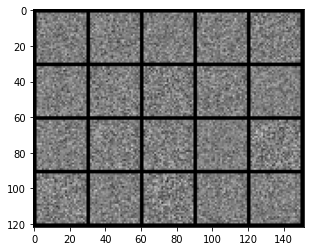

Epoch 1 : Generator's loss : 5.156627876926333, Discriminator's loss : 0.32004972874546356


  0%|          | 0/469 [00:00<?, ?it/s]

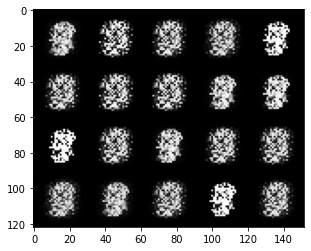

Epoch 2 : Generator's loss : 4.990225575880201, Discriminator's loss : 0.09036576355904785


  0%|          | 0/469 [00:00<?, ?it/s]

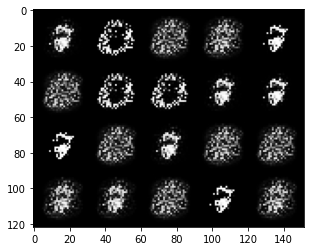

Epoch 3 : Generator's loss : 4.790425917232977, Discriminator's loss : 0.09164585693796942


  0%|          | 0/469 [00:00<?, ?it/s]

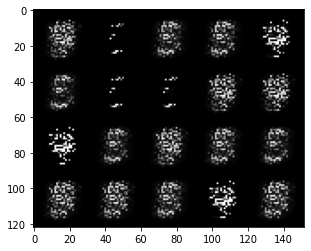

Epoch 4 : Generator's loss : 6.134608979418334, Discriminator's loss : 0.08484748684997752


  0%|          | 0/469 [00:00<?, ?it/s]

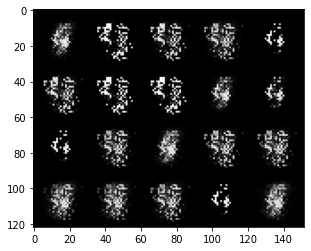

Epoch 5 : Generator's loss : 5.821422570804034, Discriminator's loss : 0.05907518946841708


  0%|          | 0/469 [00:00<?, ?it/s]

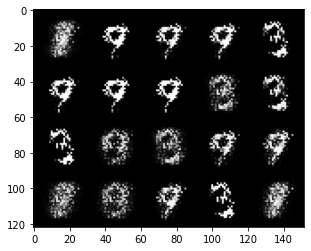

Epoch 6 : Generator's loss : 6.363902755891845, Discriminator's loss : 0.0793515986034166


  0%|          | 0/469 [00:00<?, ?it/s]

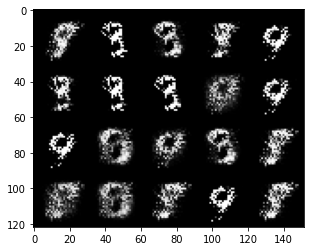

Epoch 7 : Generator's loss : 6.28182956557284, Discriminator's loss : 0.11017738948109498


  0%|          | 0/469 [00:00<?, ?it/s]

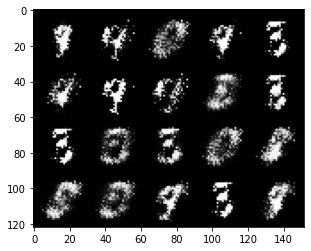

Epoch 8 : Generator's loss : 5.394394090689067, Discriminator's loss : 0.1516250960115812


  0%|          | 0/469 [00:00<?, ?it/s]

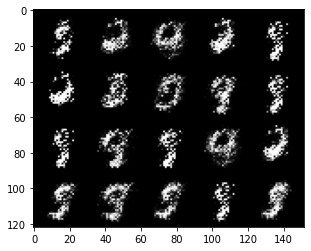

Epoch 9 : Generator's loss : 6.751026454510719, Discriminator's loss : 0.11414786155766515


  0%|          | 0/469 [00:00<?, ?it/s]

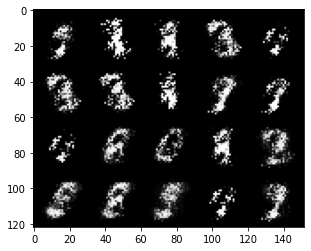

Epoch 10 : Generator's loss : 5.5829244946111745, Discriminator's loss : 0.1542194029892177


  0%|          | 0/469 [00:00<?, ?it/s]

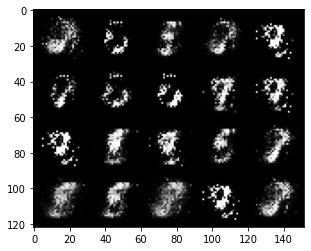

Epoch 11 : Generator's loss : 5.864808097831221, Discriminator's loss : 0.10801801206603615


  0%|          | 0/469 [00:00<?, ?it/s]

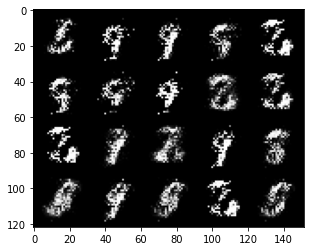

Epoch 12 : Generator's loss : 5.739929303939917, Discriminator's loss : 0.1725473501471314


  0%|          | 0/469 [00:00<?, ?it/s]

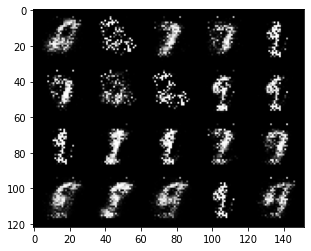

Epoch 13 : Generator's loss : 5.7732499870918454, Discriminator's loss : 0.12997930875020242


  0%|          | 0/469 [00:00<?, ?it/s]

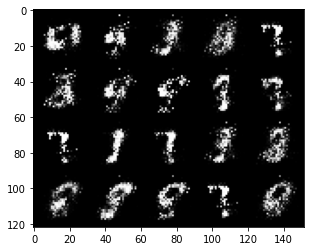

Epoch 14 : Generator's loss : 5.888929466703045, Discriminator's loss : 0.15681965811563325


  0%|          | 0/469 [00:00<?, ?it/s]

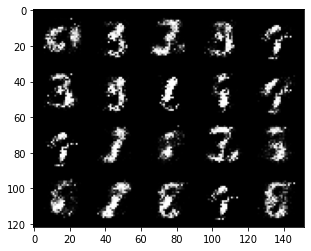

Epoch 15 : Generator's loss : 5.024815194896544, Discriminator's loss : 0.19008874480149893


  0%|          | 0/469 [00:00<?, ?it/s]

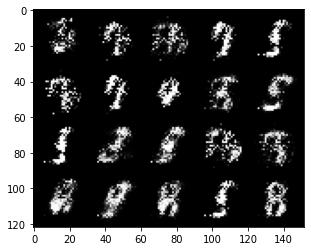

Epoch 16 : Generator's loss : 5.101161088008108, Discriminator's loss : 0.19340950808227697


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 : Generator's loss : 5.436064203664946, Discriminator's loss : 0.18754226028093143


  0%|          | 0/469 [00:00<?, ?it/s]

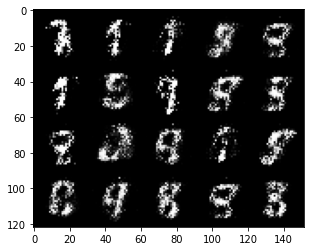

Epoch 18 : Generator's loss : 5.015283425987911, Discriminator's loss : 0.22281340126798097


  0%|          | 0/469 [00:00<?, ?it/s]

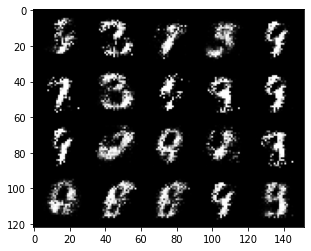

Epoch 19 : Generator's loss : 4.992996636738401, Discriminator's loss : 0.2301167432369708


  0%|          | 0/469 [00:00<?, ?it/s]

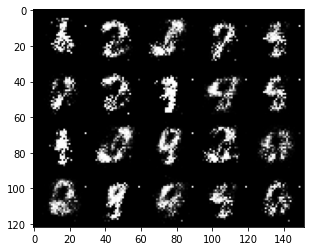

Epoch 20 : Generator's loss : 5.274341418544875, Discriminator's loss : 0.19866931790323145


  0%|          | 0/469 [00:00<?, ?it/s]

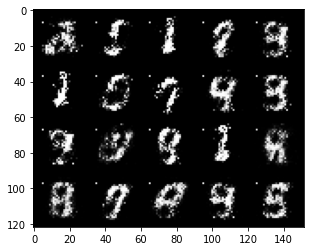

Epoch 21 : Generator's loss : 5.0582191481519105, Discriminator's loss : 0.22484711248642092


  0%|          | 0/469 [00:00<?, ?it/s]

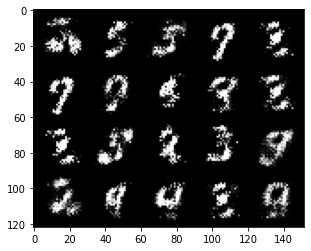

Epoch 22 : Generator's loss : 5.243345971809013, Discriminator's loss : 0.19318233460569179


  0%|          | 0/469 [00:00<?, ?it/s]

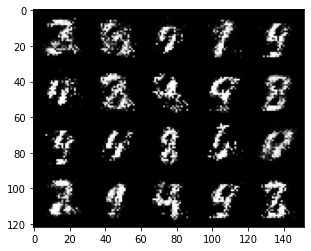

Epoch 23 : Generator's loss : 5.235330439325589, Discriminator's loss : 0.22614332168563597


  0%|          | 0/469 [00:00<?, ?it/s]

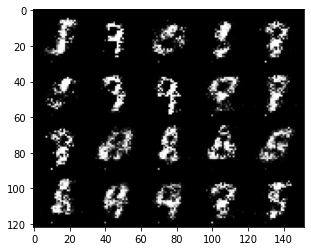

Epoch 24 : Generator's loss : 4.8374653396321765, Discriminator's loss : 0.24026959302074619


  0%|          | 0/469 [00:00<?, ?it/s]

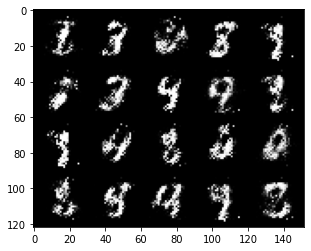

Epoch 25 : Generator's loss : 5.099224442357956, Discriminator's loss : 0.23890865659281643


  0%|          | 0/469 [00:00<?, ?it/s]

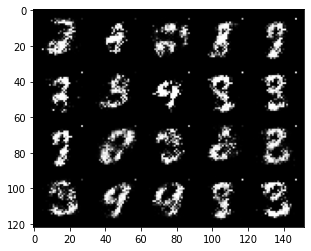

Epoch 26 : Generator's loss : 5.397383830186401, Discriminator's loss : 0.22837258533818888


  0%|          | 0/469 [00:00<?, ?it/s]

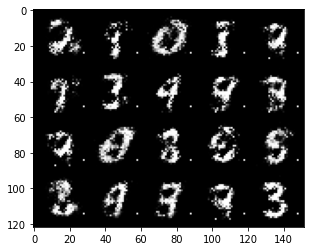

Epoch 27 : Generator's loss : 5.391131627788422, Discriminator's loss : 0.23684769297745437


  0%|          | 0/469 [00:00<?, ?it/s]

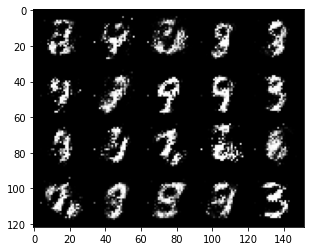

Epoch 28 : Generator's loss : 4.755161385038006, Discriminator's loss : 0.27480053885786265


  0%|          | 0/469 [00:00<?, ?it/s]

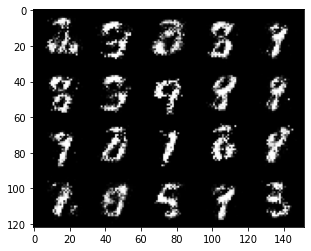

Epoch 29 : Generator's loss : 4.43544745597758, Discriminator's loss : 0.2920843373451914


  0%|          | 0/469 [00:00<?, ?it/s]

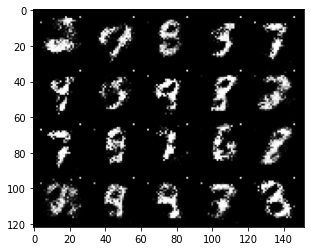

Epoch 30 : Generator's loss : 4.879225625158119, Discriminator's loss : 0.22205328135919977


  0%|          | 0/469 [00:00<?, ?it/s]

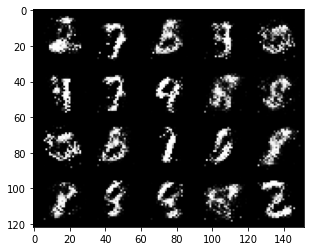

Epoch 31 : Generator's loss : 4.574808471492613, Discriminator's loss : 0.28330718015811085


  0%|          | 0/469 [00:00<?, ?it/s]

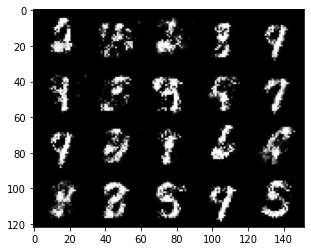

Epoch 32 : Generator's loss : 4.31003607209049, Discriminator's loss : 0.29197786346490956


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33 : Generator's loss : 4.308219177128155, Discriminator's loss : 0.29279709458033415


  0%|          | 0/469 [00:00<?, ?it/s]

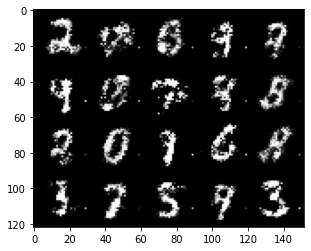

Epoch 34 : Generator's loss : 4.1086195150672244, Discriminator's loss : 0.2939862759033246


  0%|          | 0/469 [00:00<?, ?it/s]

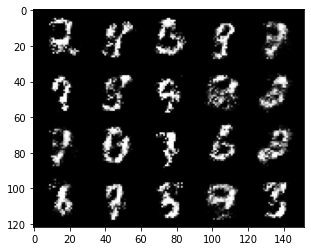

Epoch 35 : Generator's loss : 4.059797900572006, Discriminator's loss : 0.30850139755938355


  0%|          | 0/469 [00:00<?, ?it/s]

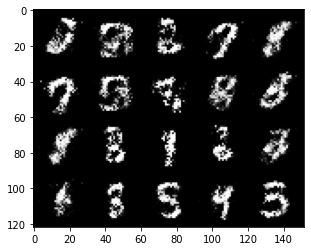

Epoch 36 : Generator's loss : 4.019917343216918, Discriminator's loss : 0.3273252634160808


  0%|          | 0/469 [00:00<?, ?it/s]

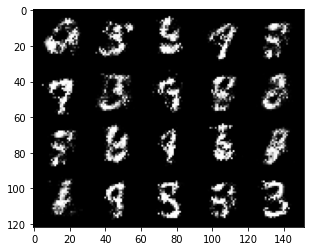

Epoch 37 : Generator's loss : 3.8851069865196246, Discriminator's loss : 0.3492566872952081


  0%|          | 0/469 [00:00<?, ?it/s]

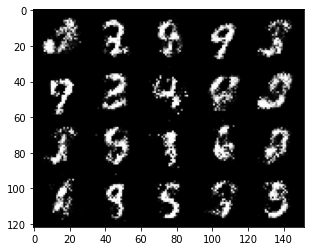

Epoch 38 : Generator's loss : 3.8532794096322456, Discriminator's loss : 0.35357020541167716


  0%|          | 0/469 [00:00<?, ?it/s]

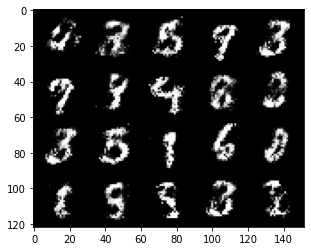

Epoch 39 : Generator's loss : 3.6806181524354002, Discriminator's loss : 0.36423253946339906


  0%|          | 0/469 [00:00<?, ?it/s]

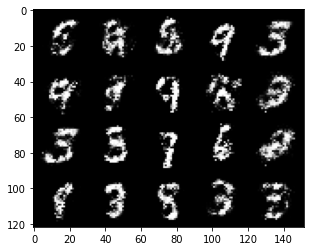

Epoch 40 : Generator's loss : 3.6769459278090424, Discriminator's loss : 0.38603458428052445


  0%|          | 0/469 [00:00<?, ?it/s]

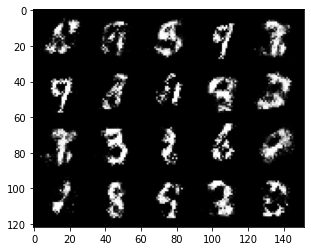

Epoch 41 : Generator's loss : 3.6349290525481135, Discriminator's loss : 0.42037500835049635


  0%|          | 0/469 [00:00<?, ?it/s]

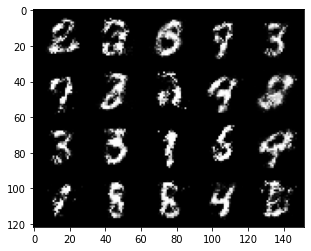

Epoch 42 : Generator's loss : 3.28449623213648, Discriminator's loss : 0.41260075953596437


  0%|          | 0/469 [00:00<?, ?it/s]

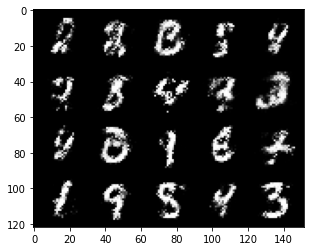

Epoch 43 : Generator's loss : 3.176226112125779, Discriminator's loss : 0.47313136319870125


  0%|          | 0/469 [00:00<?, ?it/s]

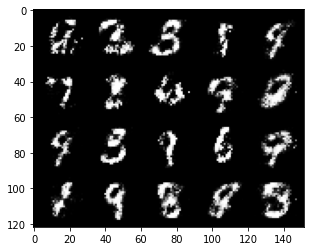

Epoch 44 : Generator's loss : 3.1298491151602286, Discriminator's loss : 0.4700531376831567


  0%|          | 0/469 [00:00<?, ?it/s]

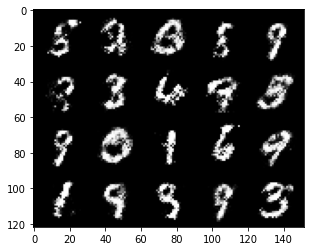

Epoch 45 : Generator's loss : 3.1363954874498248, Discriminator's loss : 0.513282639449085


  0%|          | 0/469 [00:00<?, ?it/s]

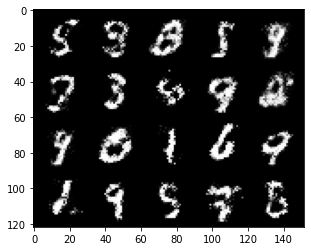

Epoch 46 : Generator's loss : 3.132124455498734, Discriminator's loss : 0.5059100296705771


  0%|          | 0/469 [00:00<?, ?it/s]

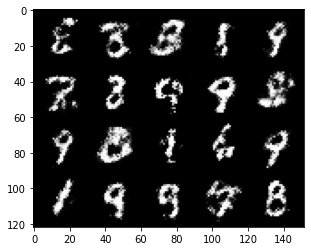

Epoch 47 : Generator's loss : 2.8884449386393336, Discriminator's loss : 0.5638042155232257


  0%|          | 0/469 [00:00<?, ?it/s]

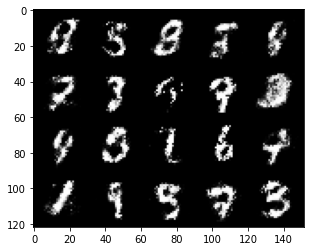

Epoch 48 : Generator's loss : 2.8831136851930923, Discriminator's loss : 0.5372176971643973


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49 : Generator's loss : 2.7384635883607844, Discriminator's loss : 0.5830917945548669


  0%|          | 0/469 [00:00<?, ?it/s]

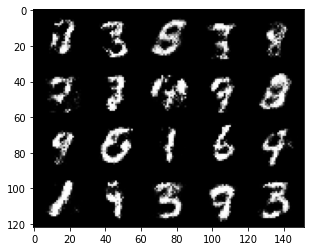

Epoch 50 : Generator's loss : 2.6347525658637982, Discriminator's loss : 0.5898762916578159


  0%|          | 0/469 [00:00<?, ?it/s]

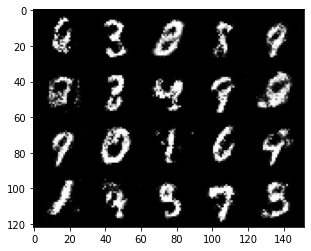

Epoch 51 : Generator's loss : 2.675773871732927, Discriminator's loss : 0.584625497428593


  0%|          | 0/469 [00:00<?, ?it/s]

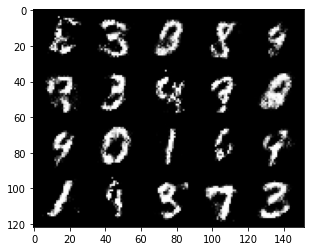

Epoch 52 : Generator's loss : 2.605220456113185, Discriminator's loss : 0.5922934243928141


  0%|          | 0/469 [00:00<?, ?it/s]

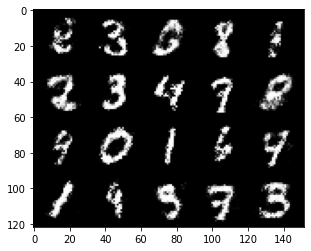

Epoch 53 : Generator's loss : 2.507755435860233, Discriminator's loss : 0.6272162240959688


  0%|          | 0/469 [00:00<?, ?it/s]

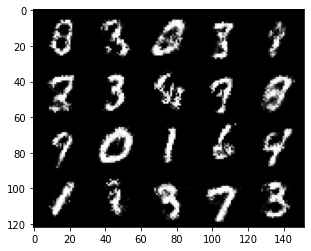

Epoch 54 : Generator's loss : 2.410682371176128, Discriminator's loss : 0.6489458810418908


  0%|          | 0/469 [00:00<?, ?it/s]

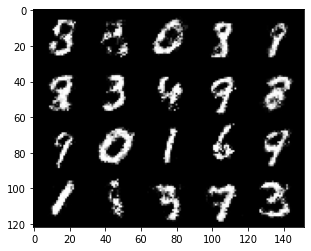

Epoch 55 : Generator's loss : 2.371833782714567, Discriminator's loss : 0.6811805967964343


  0%|          | 0/469 [00:00<?, ?it/s]

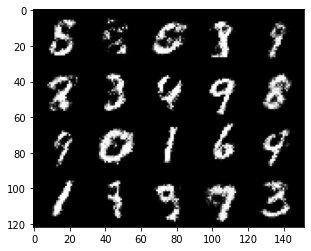

Epoch 56 : Generator's loss : 2.3213941494284915, Discriminator's loss : 0.6595117794806515


  0%|          | 0/469 [00:00<?, ?it/s]

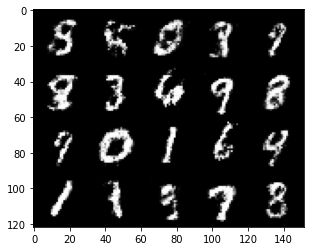

Epoch 57 : Generator's loss : 2.139479543100288, Discriminator's loss : 0.714146869904451


  0%|          | 0/469 [00:00<?, ?it/s]

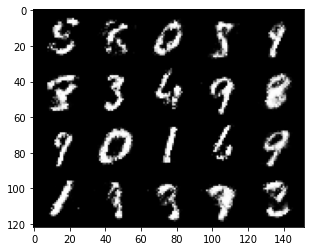

Epoch 58 : Generator's loss : 2.010376031719037, Discriminator's loss : 0.7494961835428088


  0%|          | 0/469 [00:00<?, ?it/s]

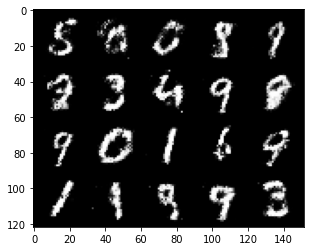

Epoch 59 : Generator's loss : 2.0061668881983645, Discriminator's loss : 0.7513387942873339


  0%|          | 0/469 [00:00<?, ?it/s]

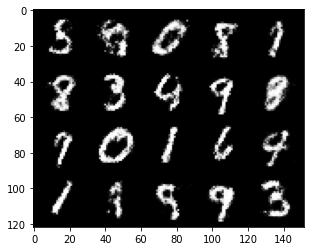

Epoch 60 : Generator's loss : 2.0147715926424525, Discriminator's loss : 0.7667099150386192


  0%|          | 0/469 [00:00<?, ?it/s]

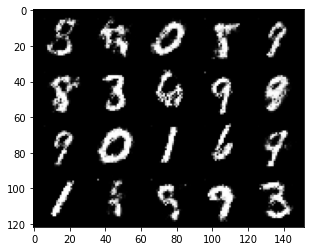

Epoch 61 : Generator's loss : 1.9678088599430728, Discriminator's loss : 0.7694965669595356


  0%|          | 0/469 [00:00<?, ?it/s]

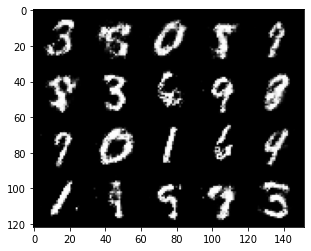

Epoch 62 : Generator's loss : 2.026122668912924, Discriminator's loss : 0.7704092858950975


  0%|          | 0/469 [00:00<?, ?it/s]

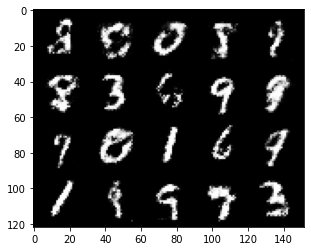

Epoch 63 : Generator's loss : 1.9472935611505244, Discriminator's loss : 0.7822486821776514


  0%|          | 0/469 [00:00<?, ?it/s]

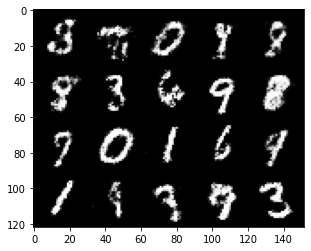

Epoch 64 : Generator's loss : 1.8274422317171402, Discriminator's loss : 0.8145960804495984


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65 : Generator's loss : 1.8572748807955906, Discriminator's loss : 0.8091917720430696


  0%|          | 0/469 [00:00<?, ?it/s]

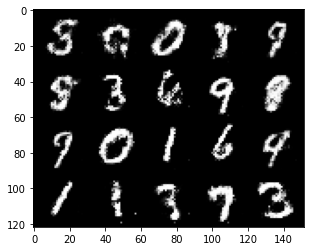

Epoch 66 : Generator's loss : 1.8560819824113013, Discriminator's loss : 0.8328539558819362


  0%|          | 0/469 [00:00<?, ?it/s]

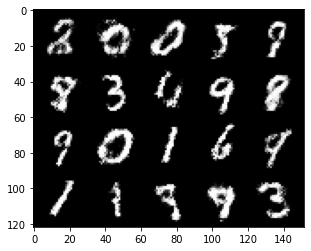

Epoch 67 : Generator's loss : 1.775925394060261, Discriminator's loss : 0.8447630634185856


  0%|          | 0/469 [00:00<?, ?it/s]

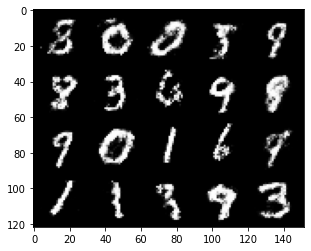

Epoch 68 : Generator's loss : 1.6832602987411434, Discriminator's loss : 0.8721304528240456


  0%|          | 0/469 [00:00<?, ?it/s]

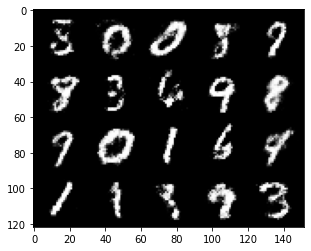

Epoch 69 : Generator's loss : 1.6230551899114907, Discriminator's loss : 0.8925035600977411


  0%|          | 0/469 [00:00<?, ?it/s]

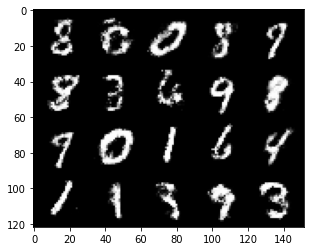

Epoch 70 : Generator's loss : 1.5981918962271229, Discriminator's loss : 0.8883494185740506


  0%|          | 0/469 [00:00<?, ?it/s]

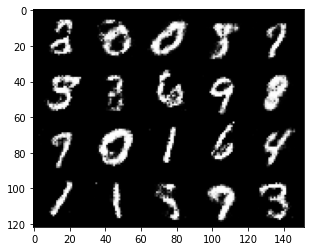

Epoch 71 : Generator's loss : 1.5914179648417655, Discriminator's loss : 0.9013503116331121


  0%|          | 0/469 [00:00<?, ?it/s]

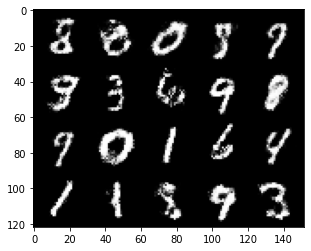

Epoch 72 : Generator's loss : 1.5972792848086814, Discriminator's loss : 0.8940457897399788


  0%|          | 0/469 [00:00<?, ?it/s]

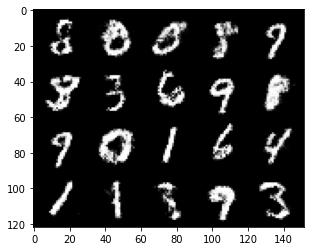

Epoch 73 : Generator's loss : 1.6311589067678716, Discriminator's loss : 0.8928297586532544


  0%|          | 0/469 [00:00<?, ?it/s]

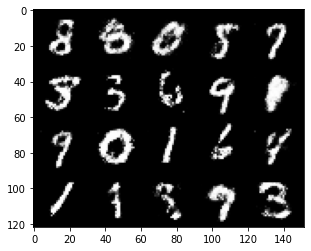

Epoch 74 : Generator's loss : 1.6374988444070064, Discriminator's loss : 0.8883302863726992


  0%|          | 0/469 [00:00<?, ?it/s]

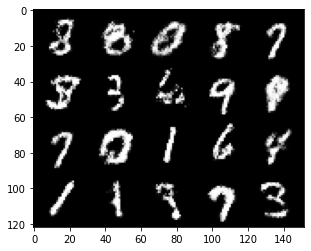

Epoch 75 : Generator's loss : 1.5413929140135678, Discriminator's loss : 0.9153018514993094


  0%|          | 0/469 [00:00<?, ?it/s]

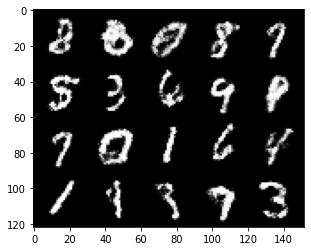

Epoch 76 : Generator's loss : 1.5221089511029502, Discriminator's loss : 0.9410440390552285


  0%|          | 0/469 [00:00<?, ?it/s]

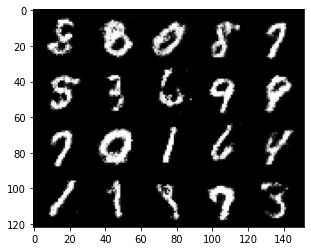

Epoch 77 : Generator's loss : 1.560432776205067, Discriminator's loss : 0.9247543628790231


  0%|          | 0/469 [00:00<?, ?it/s]

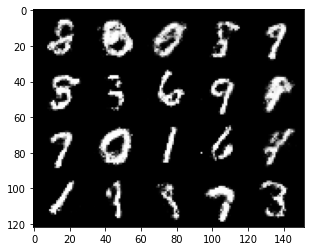

Epoch 78 : Generator's loss : 1.5361034122865591, Discriminator's loss : 0.9295983590296845


  0%|          | 0/469 [00:00<?, ?it/s]

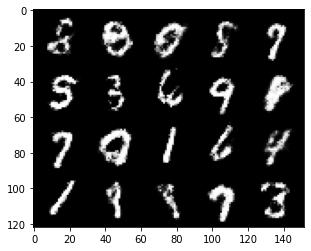

Epoch 79 : Generator's loss : 1.5222230656568938, Discriminator's loss : 0.9348751700509077


  0%|          | 0/469 [00:00<?, ?it/s]

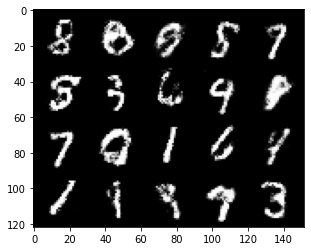

Epoch 80 : Generator's loss : 1.5335055236369053, Discriminator's loss : 0.9330027442751154


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 81 : Generator's loss : 1.4849584257678945, Discriminator's loss : 0.9422038487279847


  0%|          | 0/469 [00:00<?, ?it/s]

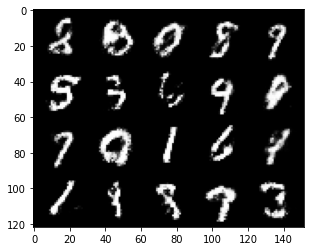

Epoch 82 : Generator's loss : 1.4791994875173833, Discriminator's loss : 0.9415932123594956


  0%|          | 0/469 [00:00<?, ?it/s]

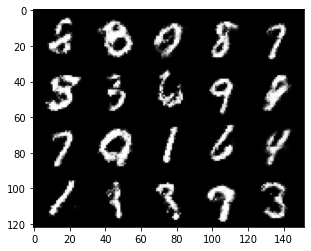

Epoch 83 : Generator's loss : 1.5373948365132184, Discriminator's loss : 0.926038099504483


  0%|          | 0/469 [00:00<?, ?it/s]

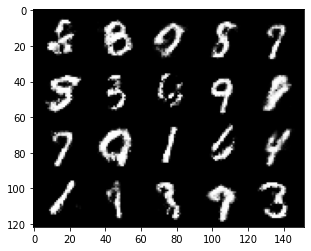

Epoch 84 : Generator's loss : 1.4979597154710846, Discriminator's loss : 0.9396007396519057


  0%|          | 0/469 [00:00<?, ?it/s]

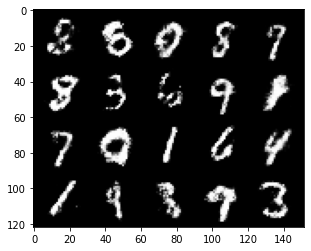

Epoch 85 : Generator's loss : 1.4750425508027392, Discriminator's loss : 0.9349440135427122


  0%|          | 0/469 [00:00<?, ?it/s]

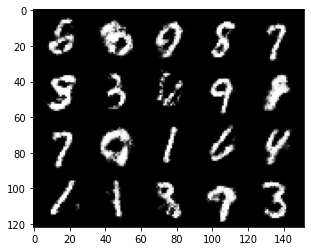

Epoch 86 : Generator's loss : 1.492719363810411, Discriminator's loss : 0.9383532834459724


  0%|          | 0/469 [00:00<?, ?it/s]

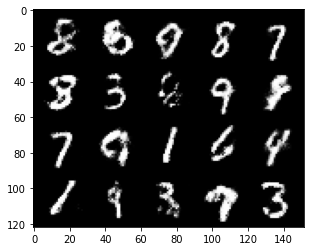

Epoch 87 : Generator's loss : 1.4878111372370202, Discriminator's loss : 0.9424374521668277


  0%|          | 0/469 [00:00<?, ?it/s]

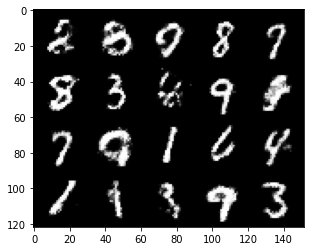

Epoch 88 : Generator's loss : 1.4681802939758626, Discriminator's loss : 0.9453561436901214


  0%|          | 0/469 [00:00<?, ?it/s]

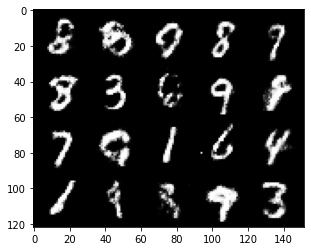

Epoch 89 : Generator's loss : 1.4482677653908476, Discriminator's loss : 0.9633182678649674


  0%|          | 0/469 [00:00<?, ?it/s]

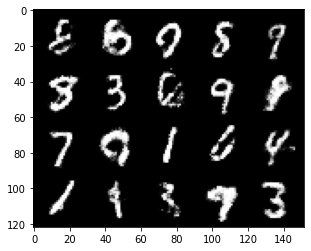

Epoch 90 : Generator's loss : 1.4252647558000804, Discriminator's loss : 0.9648339312468002


  0%|          | 0/469 [00:00<?, ?it/s]

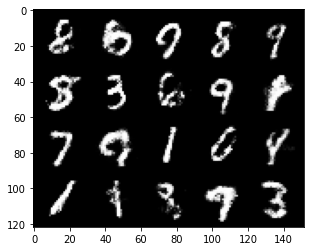

Epoch 91 : Generator's loss : 1.4549520712163149, Discriminator's loss : 0.9570865784880958


  0%|          | 0/469 [00:00<?, ?it/s]

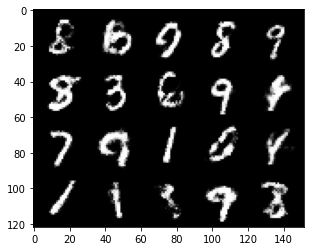

Epoch 92 : Generator's loss : 1.4395819742288163, Discriminator's loss : 0.9564651943473165


  0%|          | 0/469 [00:00<?, ?it/s]

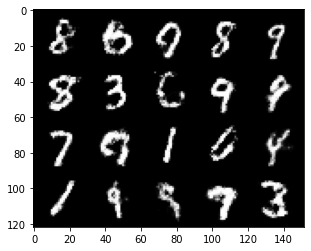

Epoch 93 : Generator's loss : 1.4400655806445872, Discriminator's loss : 0.9660352998450875


  0%|          | 0/469 [00:00<?, ?it/s]

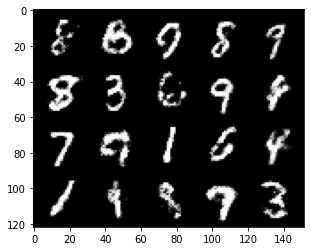

Epoch 94 : Generator's loss : 1.4357653734272222, Discriminator's loss : 0.9654827989749054


  0%|          | 0/469 [00:00<?, ?it/s]

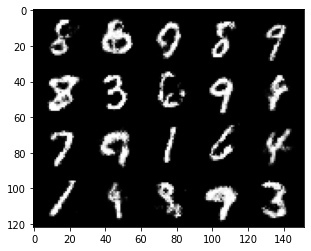

Epoch 95 : Generator's loss : 1.4362400172870042, Discriminator's loss : 0.9710326542986482


  0%|          | 0/469 [00:00<?, ?it/s]

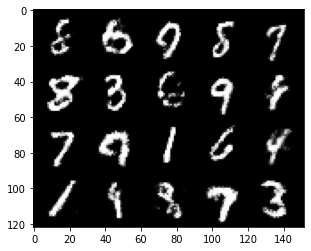

Epoch 96 : Generator's loss : 1.4175215923964088, Discriminator's loss : 0.977791477495165


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 97 : Generator's loss : 1.4080695841612338, Discriminator's loss : 0.9853143491216306


  0%|          | 0/469 [00:00<?, ?it/s]

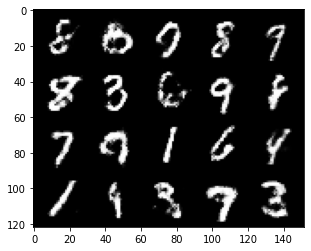

Epoch 98 : Generator's loss : 1.394897869146709, Discriminator's loss : 0.9883994307599342


  0%|          | 0/469 [00:00<?, ?it/s]

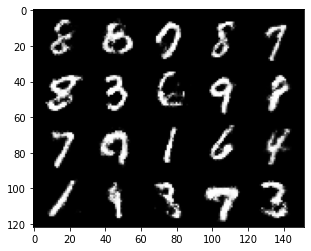

Epoch 99 : Generator's loss : 1.4206128888038685, Discriminator's loss : 0.9776630798128368


  0%|          | 0/469 [00:00<?, ?it/s]

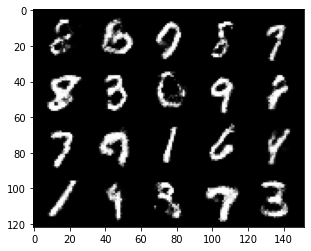

Epoch 100 : Generator's loss : 1.3890603546903078, Discriminator's loss : 0.9870512468982607


In [29]:
num_epochs = 100 # number of epochs

batch_size = 128 # number of images in a batch

criterion = nn.BCELoss() # object to compute loss of generator and discriminator

learning_rate = 0.0002 # larning rate of the optimizers

generator_optim = torch.optim.Adam(generator.parameters(), lr = learning_rate) # generator's optimizer

discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr = learning_rate) # discriminator's optimizer

# MNIST data loader
data_loader = DataLoader(MNIST('.', download = True, transform = transforms.ToTensor()), 
                        batch_size = batch_size, shuffle = True)

curr_step = 0

noise_for_gif = torch.randn((20, noise_dim), device = device)
images_for_gif = []

for epoch in range(num_epochs):

    mean_generator_loss = 0
    mean_discriminator_loss = 0
    counter = 0
    
    for real_images, _ in tqdm(data_loader):
        
        curr_batch_size = real_images.shape[0] # number of real images in a batch
        real_images = real_images.view(curr_batch_size, -1).to(device) # flatten images
        
        # train discriminator
        
        noise_vectors = torch.randn(curr_batch_size, noise_dim, device = device) # random noise vectors
        discriminator_optim.zero_grad() # set gradients of tensors to 0.
        discriminator_loss = get_discriminator_loss(generator, discriminator, criterion, noise_vectors, real_images)
        discriminator_loss.backward(retain_graph = True) # compute the gradients
        discriminator_optim.step() # optimize using gradients
        
        # train generator
        
        noise_vectors = torch.randn(curr_batch_size, noise_dim, device = device) # random noise vectors
        generator_optim.zero_grad() # set gradients of tensors to 0.
        generator_loss = get_generator_loss(generator, discriminator, criterion, noise_vectors)
        generator_loss.backward(retain_graph = True) # compute the gradients
        generator_optim.step() # optimize using gradients

        mean_generator_loss += generator_loss.item()
        mean_discriminator_loss += discriminator_loss.item()
        counter += 1

        if (curr_step % 500) == 0:
            fake_images = generator(noise_for_gif)
            show_images(fake_images, (1,28,28))
            images = (fake_images + 1) / 2
            images = images.detach().cpu()
            image_grid = make_grid(images.view(20, 1,28,28), nrow = 5).permute(1,2,0)
            image_grid_arr = (255 * image_grid.numpy()).astype(np.uint8)
            images_for_gif.append(Image.fromarray(image_grid_arr))
        curr_step += 1
    
    mean_generator_loss /= counter
    mean_discriminator_loss /= counter
    
    # print current losses
    print(f"Epoch {epoch+1} : Generator's loss : {mean_generator_loss}, Discriminator's loss : {mean_discriminator_loss}")

<h3>generate images using trained GAN</h3>

In [30]:
num_images = 20

noise_vectors = torch.randn(num_images, noise_dim, device = device)

fake_images = generator(noise_vectors)

<h3>show fake images</h3>

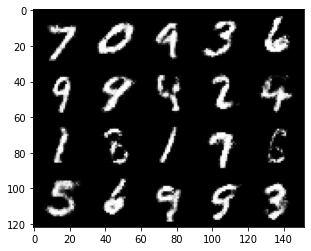

In [31]:
show_images(fake_images, (1,28,28))

<h3>show real images</h3>

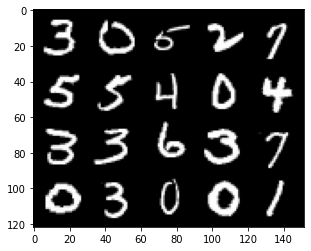

In [32]:
real_images = real_images[:20].view(-1, 28, 28)

show_images(real_images, (1, 28, 28))

<h3>Save training GIF</h3>

In [33]:
images_for_gif[0].save(f'/content/gdrive/My Drive/digit_mlp.gif', save_all = True, append_images=images_for_gif[1:], optimize=False, duration=300, loop=0)